# MIE1624 Assignment 2
#### Author: Tiana Wei 1004698216
#### Date: Nov. 2, 2020


## Data Analysis Walk Through
### 1. Feature engineering
Data exploration, data cleaning, handle missing values

### 2. Feature selection
Recursive feature elimination to select the top 10 most informative features.

### 3.+ 4. Model Implementation + hyperprameter tuning
#### - 10-fold cross validation mean and variance of model accuracy. 
#### - Hyperparameter tuning to find the optimal model.
#### - Bias-variance trade-off justification of the optimal model

### 5. Testing and Discussion
Optimal model performance on training and test data and discussion on the overall fit
    

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# suppress chained assignment warning for the following for loop assignment
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
df = pd.read_csv("Kaggle_Salary.csv", low_memory = False)

# (1) Exploratory data analysis and data cleaning

In [3]:
# drop all the columns with more than 80% of NA since those columns are unlikely to be a useful predictor.
df = df.dropna(thresh = len(df)*0.2, axis = 1)

In [4]:
# drop the column for survey time (not useful in predicting salary)
df = df.drop('Time from Start to Finish (seconds)', axis = 1)

In [5]:
# drop columns for the choice 'None' in multiple choice questions
#df = df[df.columns[(df.iloc[0,].str.endswith('None') == False) | (df.iloc[0,].str.endswith('None').isnull())]]

In [6]:
# drop all the columns whose names end in "_TEXT" since these columns 
# do not give use extra information to the choices under each question
df = df[df.columns[~df.columns.str.endswith('_TEXT')]]

In [7]:
# drop the row for question text for the ease of plotting later on
df = df.drop([0]).reset_index(drop = True)

## For all the multiple choice questions, transform them into one-hot encoding for now and use feature selection to eliminate non-useful choices later on.

In [8]:
# Question numbers that are multiple choice questions
multi_choiceQs = [9,12,13]+list(range(16,22))+list(range(24,35))
multi_choiceQs

[9, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [9]:
# create a dictionary that holds all the columns under each multiple choice question
name = {}
for i in range(len(multi_choiceQs)):
    name['Q'+ str(multi_choiceQs[i])+'_columns'] = [col for col in df if col.startswith('Q'+ str(multi_choiceQs[i]))]

In [10]:
# assign one-hot encoding to each columns under each multiple question
for i in name:
    for x in name[i]:
        df.loc[df[x].notnull(),x] = 1
        df.loc[df[x].isnull(),x] = 0

## For all the non-multiple choice questions, take the following steps for feature engineering:

#### (1) Explore each question's relation to the encoded salary.

#### (2) Handle missing values:
    a. If very few missing value, remove the datapoints (rows) with missing values.
    b. If there is a considerable number of missing value, inspect relation between the datapoints with missing values and salary compared to the relation between datapoints without missing values and salary. If the datapoints with and without missing values have the same trend, replace the missing values with the mode. Otherwise, drop the rows with missing values. 
    
#### (3) Convert categorical data that contain ordinal values into numerical data by encoding.

#### (4) For the nominal data that make no sense to be encoded as numerical data: 
#### Based on observed patterns from (1), group bins into bigger buckets if possible to reduce the cost of dummy coding.

#### (5) Drop some categories with few responses under each question to reduce the cost of dummy coding.

#### (6) For the variables that have no logic in further grouping or dropping, I will one-hot code all choices for now and leave them for feature selection later on.

### Age and salary

<AxesSubplot:xlabel='Q1', ylabel='Q10_Encoded'>

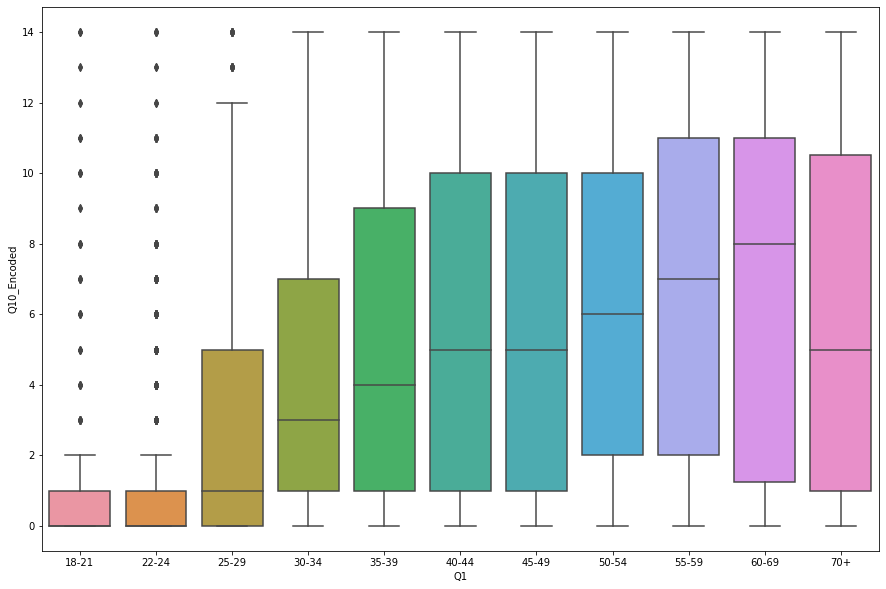

In [11]:
# plot age and salary
plt.figure(figsize=(15,10))
sns.boxplot(x='Q1', y='Q10_Encoded', data=df.sort_values('Q1'))

We can see that there is a trend of increasing salary with increasing age. Since age contains an inherent order, we can encode the age groups as numbers 0~10.

In [12]:
# check no missing data
df[df['Q1'].isnull()]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,...,Q28_Part_5,Q28_Part_6,Q29_Part_2,Q30_Part_11,Q31_Part_11,Q32_Part_11,Q33_Part_11,Q34_Part_1,Q10_Encoded,Q10_buckets


In [13]:
# encode each age range as numerical data
age_encode = {
    '18-21': 0,
    '22-24': 1,
    '25-29': 2,
    '30-34': 3,
    '35-39': 4,
    '40-44': 5,
    '45-49': 6,
    '50-54': 7,
    '55-59': 8,
    '60-69': 9,
    '70+': 10
}
# map the encoding onto a new column called Q1_Encoded
df.loc[:,'Q1'] = df.loc[:,'Q1'].map(age_encode)

<AxesSubplot:xlabel='Q1', ylabel='Q10_Encoded'>

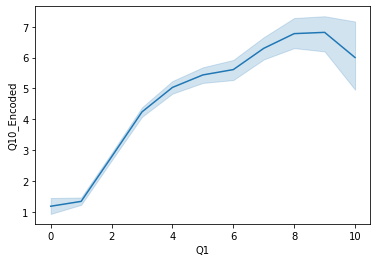

In [14]:
sns.lineplot(data=df,
            x="Q1",
            y="Q10_Encoded")

We can see a clear trend of increased salary with increased age untill age 60-69 (encoded as 9).

### Gender and salary

In [15]:
df.groupby('Q2').size()

Q2
Female                      1827
Male                       10473
Prefer not to say            167
Prefer to self-describe       30
dtype: int64

In [16]:
# since very few other answers, only take male or female response
df = df[(df['Q2'] == 'Male') | (df['Q2'] == 'Female')]

<AxesSubplot:xlabel='Q2', ylabel='Q10_Encoded'>

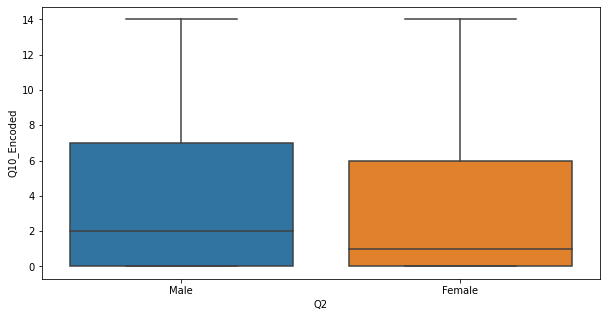

In [17]:
# plot gender and salary
plt.figure(figsize=(10,5))
sns.boxplot(x='Q2', y='Q10_Encoded', data=df)

Male's salary seems to be higher than female on average. Though without statistical significance, gender can be a useful predictor for salary.

In [18]:
# dummy code
df = pd.get_dummies(data=df, columns=['Q2'])

## country and salary

In [19]:
# look at all possible answers
#df.groupby('Q3').size()

In [20]:
# drop columns with other countries since we don't know what composed the other countries
df = df[df['Q3'] != 'Other'].reset_index(drop = True)

In [21]:
# check no missing data for country
df[df.Q3.isnull()]

,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,...,Q29_Part_2,Q30_Part_11,Q31_Part_11,Q32_Part_11,Q33_Part_11,Q34_Part_1,Q10_Encoded,Q10_buckets,Q2_Female,Q2_Male


Since there are too many countries, to reduce the cost of dummy coding, we can group countries according to the world regions.

In [22]:
# label countries with their world regions
Africa = ['Nigeria','South Africa','Egypt','Morocco','Kenya','Algeria','Tunisia']
Asia = ['India','Pakistan','Japan','South Korea','Indonesia','Hong Kong (S.A.R.)','Taiwan','Thailand',
        'Viet Nam','Singapore','Bangladesh','China','Philippines','Malaysia','Republic of Korea']
Middle_east = ['Israel','Iran, Islamic Republic of...','Saudi Arabia']
Europe = ['Russia','Ukraine','Belarus','United Kingdom of Great Britain and Northern Ireland','Turkey',
          'Switzerland','Norway']
EU = ['France','Netherlands','Germany','Ireland','Greece','Sweden','Portugal','Poland','Italy',
      'Czech Republic','Spain','Hungary','Romania','Belgium','Austria','Denmark']
North_America = ['United States of America','Canada']
Oceania = ['Australia','New Zealand']
Central_South_America = ['Brazil','Mexico','Chile','Argentina','Colombia','Peru']

# create a new column called world_region
df['world_region'] = ""

# loop through each region list to add to world_region
for i in range(len(df)):
    if df['Q3'][i] in Africa:
        df['world_region'][i] = 'Africa'
    elif df['Q3'][i] in Asia:
        df['world_region'][i] = 'Asia'
    elif df['Q3'][i] in Middle_east:
        df['world_region'][i] = 'Middle_east'
    elif df['Q3'][i] in Europe:
        df['world_region'][i] = 'Europe'
    elif df['Q3'][i] in EU:
        df['world_region'][i] = 'EU'
    elif df['Q3'][i] in North_America:
        df['world_region'][i] = 'North_America'
    elif df['Q3'][i] in Oceania:
        df['world_region'][i] = 'Oceania'
    else:
        df['world_region'][i] = 'Central_South_America'
        
df.head()

,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,...,Q30_Part_11,Q31_Part_11,Q32_Part_11,Q33_Part_11,Q34_Part_1,Q10_Encoded,Q10_buckets,Q2_Female,Q2_Male,world_region
0,1,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,0,0,0,...,0,0,0,0,0,3.0,"30,000-39,999",0,1,EU
1,5,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",1,1,1,...,0,0,0,0,0,0.0,"0-9,999",0,1,Asia
2,5,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,0,0,0,...,0,0,0,1,0,14.0,">250,000",0,1,Oceania
3,1,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),0,0,0,...,0,0,0,0,0,0.0,"0-9,999",0,1,Asia
4,7,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",0,0,1,...,0,0,0,0,0,6.0,"60,000-69,999",0,1,EU


In [23]:
# make sure no missing values for world region
df[df['world_region'].isnull()]

,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,...,Q30_Part_11,Q31_Part_11,Q32_Part_11,Q33_Part_11,Q34_Part_1,Q10_Encoded,Q10_buckets,Q2_Female,Q2_Male,world_region


<AxesSubplot:xlabel='world_region', ylabel='Q10_Encoded'>

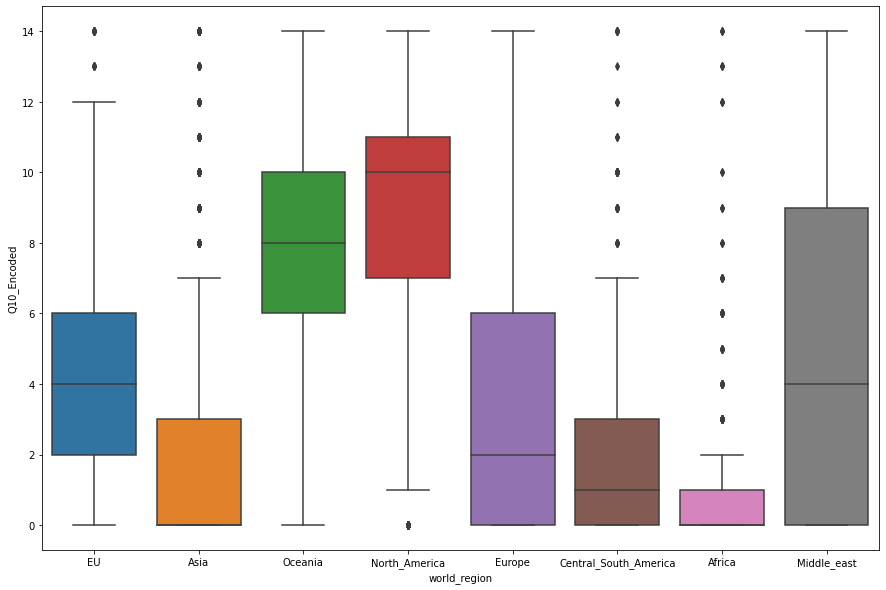

In [24]:
plt.figure(figsize=(15,10))
sns.boxplot(x='world_region',y='Q10_Encoded',data=df)

Annual salaries from different world regions differ from each other. It seems that North America and Oceania countries have the highest median salary. Then, European countries and EU countires and middle east have the middle ground, while Asian, central and sount America, and Africa have the lowest median salary. To further reduce the number of categories, we can further group these 8 countries into three groups - NorthAmerica+Oceania, Europe+EU+MiddleEast, and Asia+CSAmerica+Africa.

In [25]:
for i in range(len(df)):
    if (df['world_region'][i] == 'North_America') or (df['world_region'][i] == 'Oceania'):
        df['world_region'][i] = 'NAmerica_Oceania'
    elif (df['world_region'][i] == 'EU') or (df['world_region'][i] == 'Europe') or (df['world_region'][i] == 'Middle_east'):
        df['world_region'][i] = 'Europe_MidEast'
    else:
        df['world_region'][i] = 'Asia_CSAmerica_Africa'


<AxesSubplot:xlabel='world_region', ylabel='Q10_Encoded'>

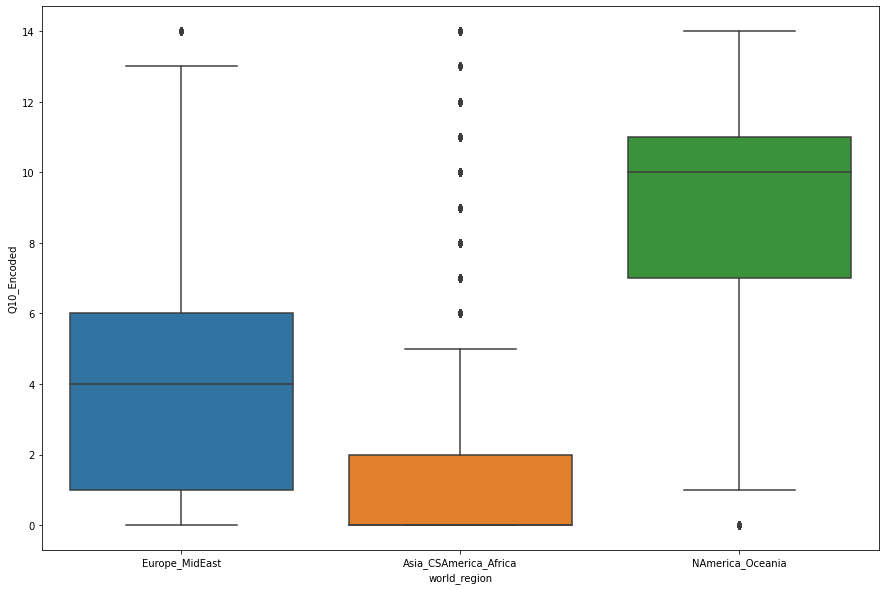

In [26]:
plt.figure(figsize=(15,10))
sns.boxplot(x='world_region',y='Q10_Encoded',data=df)

There seems to be enough salary differene between these three world region groups. Categorizing all data into these three region groups can be helpful in building a model that predicts salary.

In [27]:
## dummy code for world region
df = pd.get_dummies(data=df, columns=['world_region'])

## Education and salary

In [28]:
# look at the number of sample for each response
df.groupby('Q4').size()

Q4
Bachelor’s degree                                                    3155
Doctoral degree                                                      1922
I prefer not to answer                                                160
Master’s degree                                                      5477
No formal education past high school                                  110
Professional degree                                                   434
Some college/university study without earning a bachelor’s degree     366
dtype: int64

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q4'>

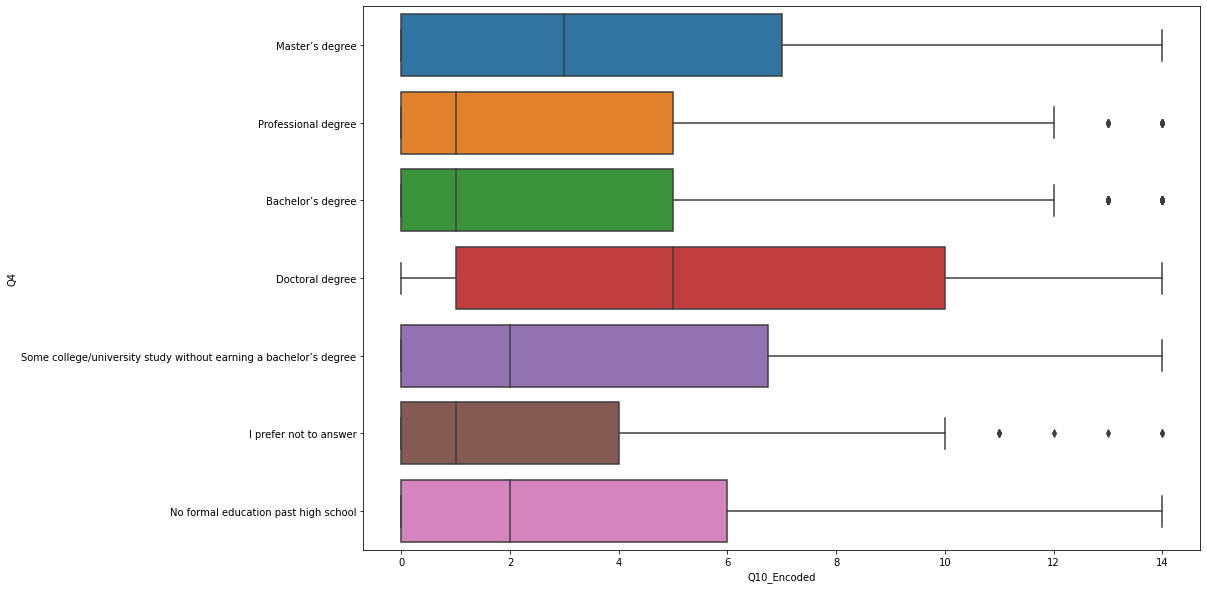

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Q10_Encoded',y='Q4',data=df)

It seems like the biggest differences lie between Doctoral, Master's, and Bachelor's degree. Plus, these three education groups have the most samples. We can decide to include only these three education classes.

In [30]:
df = df[(df['Q4'] == 'Bachelor’s degree') | (df['Q4'] == 'Master’s degree') | (df['Q4'] == 'Doctoral degree')].reset_index(drop = True)

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q4'>

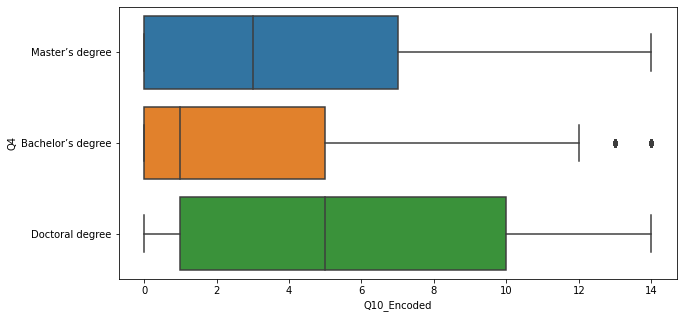

In [31]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q4',data=df)

In [32]:
# dummy code education degrees
df = pd.get_dummies(data=df, columns=['Q4'])

## Title and salary

In [33]:
# look at the number of poeple choosing different choices
df.groupby('Q5').size()

Q5
Business Analyst            568
DBA/Database Engineer        98
Data Analyst               1170
Data Engineer               466
Data Scientist             3235
Other                      1187
Product/Project Manager     549
Research Scientist         1109
Software Engineer          1953
Statistician                219
dtype: int64

In [34]:
# check no missing value
df[df['Q5'].isnull()]

,Q1,Q3,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,...,Q10_Encoded,Q10_buckets,Q2_Female,Q2_Male,world_region_Asia_CSAmerica_Africa,world_region_Europe_MidEast,world_region_NAmerica_Oceania,Q4_Bachelor’s degree,Q4_Doctoral degree,Q4_Master’s degree


<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q5'>

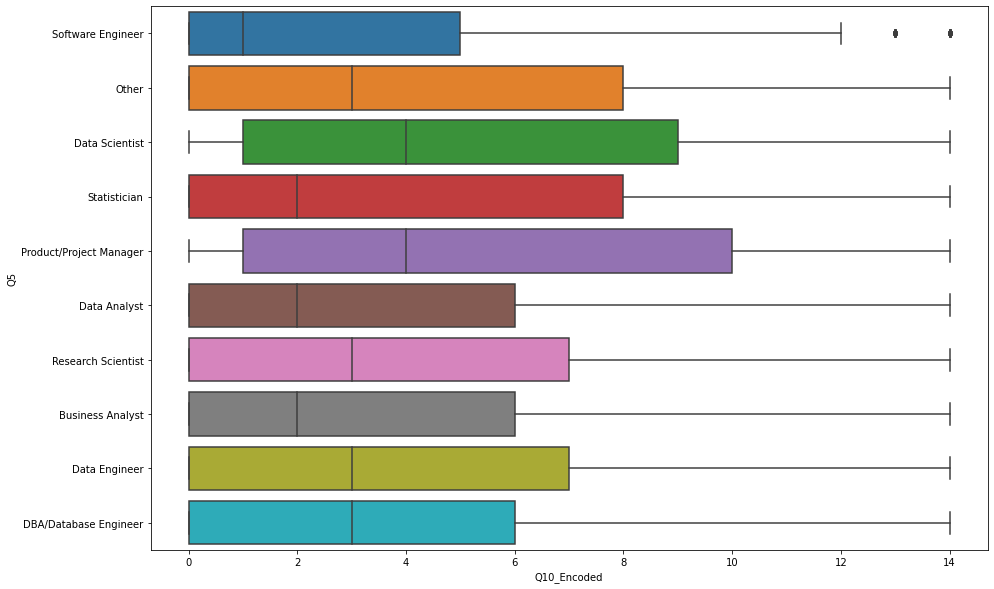

In [35]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Q10_Encoded',y='Q5',data=df)

In [36]:
df.groupby(['Q5'])['Q10_Encoded'].mean()

Q5
Business Analyst           3.320423
DBA/Database Engineer      3.795918
Data Analyst               3.100855
Data Engineer              4.141631
Data Scientist             4.827202
Other                      4.346251
Product/Project Manager    5.316940
Research Scientist         3.882777
Software Engineer          3.259601
Statistician               3.940639
Name: Q10_Encoded, dtype: float64

I can't find a rule to group the different work titles into bigger groups. Therefore, I will go on and dummy code them and leave them to feature selection later to eliminate non-useful choices for salary prediction.

In [37]:
# dummy code
df = pd.get_dummies(data=df, columns=['Q5'])

## Company size and salary

In [38]:
# check number of responses in each choice
df.groupby('Q6').size()

Q6
0-49 employees          2823
1000-9,999 employees    2098
250-999 employees       1397
50-249 employees        1699
> 10,000 employees      2537
dtype: int64

In [39]:
# check missing value
df[df['Q6'].isnull()]

,Q1,Q3,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician


<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q6'>

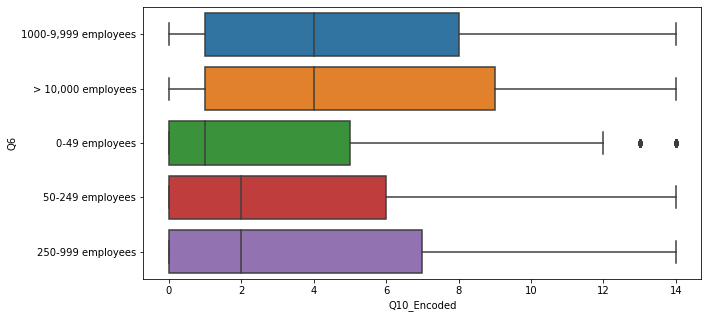

In [40]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q6',data=df)

Since number of employees has an inherent order, we can encode this variable into numerical data.

In [41]:
# encode each bin as numerical data
Q6_encode = {
    '0-49 employees': 0,
    '50-249 employees': 1,
    '250-999 employees': 2,
    '1000-9,999 employees': 3,
    '> 10,000 employees': 4
}
# map the encoding
df.loc[:,'Q6'] = df.loc[:,'Q6'].map(Q6_encode)

<AxesSubplot:xlabel='Q6', ylabel='Q10_Encoded'>

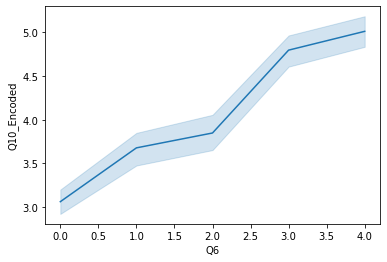

In [42]:
sns.lineplot(data=df,
            x="Q6",
            y="Q10_Encoded")

We can see that there is a trend of increased salary with increased size of the company (number of employee in the company).

## Number of data science worker in company and salary

In [43]:
df.groupby('Q7').size()

Q7
0        1336
1-2      2271
10-14     767
15-19     340
20+      2578
3-4      1817
5-9      1445
dtype: int64

In [44]:
df[df['Q7'].isnull()]

,Q1,Q3,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician


<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q7'>

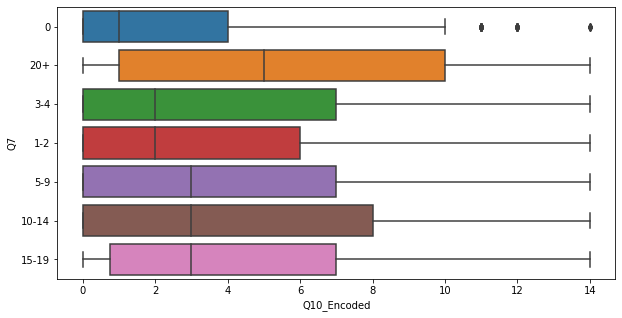

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q7',data=df)

Number of data science worker has an inherent order: encode them as numerical data.

In [46]:
# encode each bin as numerical data
Q7_encode = {
    '0': 0,
    '1-2': 1,
    '3-4': 2,
    '5-9': 3,
    '10-14': 4,
    '15-19': 5,
    '20+': 6
}
# map the encoding
df.loc[:,'Q7'] = df.loc[:,'Q7'].map(Q7_encode)

<AxesSubplot:xlabel='Q7', ylabel='Q10_Encoded'>

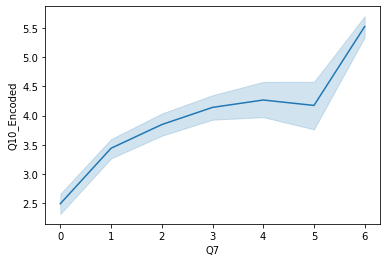

In [47]:
sns.lineplot(data=df,
            x="Q7",
            y="Q10_Encoded")

Generally, there is a trend of increased salary with increased number of data science worker, with a dip for 15-19 data science worker.

# ML in business or not and salary

In [48]:
df.groupby('Q8').size()

Q8
I do not know                                                                                 900
No (we do not use ML methods)                                                                1805
We are exploring ML methods (and may one day put a model into production)                    2207
We have well established ML methods (i.e., models in production for more than 2 years)       2139
We recently started using ML methods (i.e., models in production for less than 2 years)      2234
We use ML methods for generating insights (but do not put working models into production)    1269
dtype: int64

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q8'>

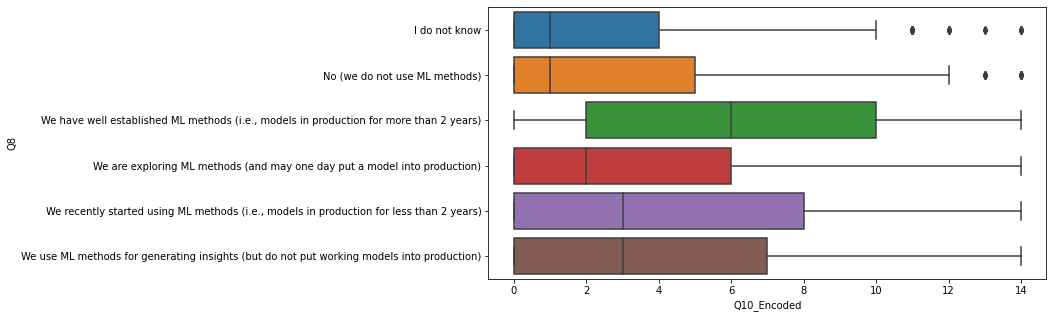

In [49]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q8',data=df)

We can generalize the answers into Yes and No to using ML in general. 

In [50]:
for i in range(len(df)):
    if (df['Q8'][i] == 'I do not know') or (df['Q8'][i] == 'No (we do not use ML methods)') or (df['Q8'][i] == 'We are exploring ML methods (and may one day put a model into production)'):
        df['Q8'][i] = 'No'
    else:
        df['Q8'][i] = 'Yes'


<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q8'>

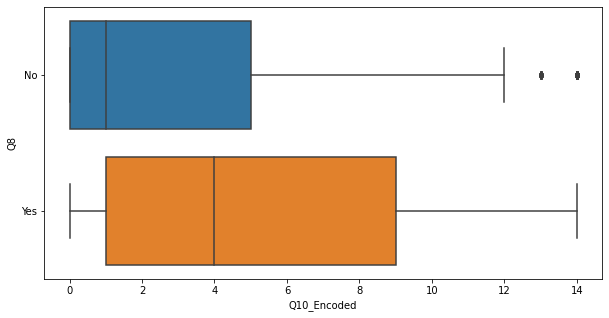

In [51]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q8',data=df)

In [52]:
# dummy code
df = pd.get_dummies(data=df, columns=['Q8'])

## Money spent on ML and salary

In [53]:
# there is nan
df['Q11'].unique()

array(['$0 (USD)', '$10,000-$99,999', '$100-$999', '$1000-$9,999',
       '> $100,000 ($USD)', '$1-$99', nan], dtype=object)

In [54]:
df.groupby('Q11').size()

Q11
$0 (USD)             3364
$1-$99               1241
$10,000-$99,999      1097
$100-$999            1974
$1000-$9,999         1805
> $100,000 ($USD)     876
dtype: int64

In [55]:
# number of nan rows
df['Q11'].isnull().sum(axis = 0)

197

There are 197 rows with no answer to Q11. I can choose to drop them or replace them with the mode, which is "0 USD" in this case.
Let's see if there is a difference in the salary distribution of the people who did and didn't answer Q11.

In [56]:
# compare normalized distribution of the encoded salary values between missing and non-missing value datapoints
a = df['Q10_Encoded'].value_counts(normalize=True)
b = df[df['Q11'].isnull()]['Q10_Encoded'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN Q11':b}))

       Alldata   NaN Q11
0.0   0.307182  0.451777
1.0   0.108584  0.055838
2.0   0.078738  0.081218
3.0   0.058272  0.065990
4.0   0.056945  0.040609
5.0   0.058745  0.035533
6.0   0.048133  0.065990
7.0   0.043870  0.025381
8.0   0.034395  0.030457
9.0   0.032784  0.045685
10.0  0.062441  0.035533
11.0  0.042164  0.030457
12.0  0.036669  0.005076
13.0  0.013265  0.020305
14.0  0.017813  0.010152


The distribution of the population in the salary bins seems quite different between those who answered Q11 and those who didn't (e.g., see salary bins of 5,6,7,10,12,etc). This means that those who didn't answer Q11 are not randomly distributed accross the surveyed population. In this case, it may be safer to drop those samples instead of replacing them with the mode to Q11. Plus, 197 rows are not too many data to drop.

In [57]:
# droping na rows
df = df.dropna(subset = ['Q11']).reset_index(drop = True)

Since the money spent on ML contains ordered values, we can convert them into numerical data.

In [58]:
# encode each bin as numerical data
Q11_encode = {
    '$0 (USD)': 0,
    '$1-$99': 1,
    '$100-$999': 2,
    '$1000-$9,999': 3,
    '$10,000-$99,999': 4,
    '> $100,000 ($USD)': 5
}
# map the encoding
df.loc[:,'Q11'] = df.loc[:,'Q11'].map(Q11_encode)

<AxesSubplot:xlabel='Q11', ylabel='Q10_Encoded'>

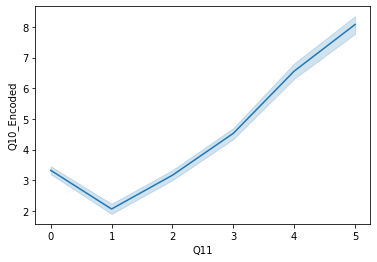

In [59]:
sns.lineplot(data=df,
            x="Q11",
            y="Q10_Encoded")

A clear trend of increased salary with increased amount of monet spent on ML above $1 USD.

## Analysis tool used and salary

In [60]:
# let's look at how many poeple chose each choice
df.groupby('Q14').size()

Q14
Advanced statistical software (SPSS, SAS, etc.)                          622
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       1681
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     661
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                 885
Local development environments (RStudio, JupyterLab, etc.)              5154
Other                                                                    723
dtype: int64

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q14'>

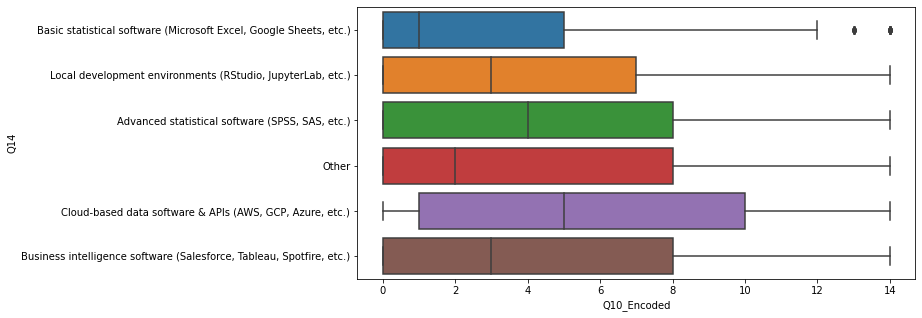

In [61]:
# plot the relation between tool used and salary
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q14',data=df)

No apparent logic in grouping the choices. Therefore, I will dummy code all choices for now and let feature selection eliminate non-useful choices later on.

In [62]:
# dummy code
df = pd.get_dummies(data=df, columns=['Q14'])

## Coding experience and salary

In [63]:
# there is nan
df['Q15'].unique()

array(['1-2 years', '< 1 years', '20+ years', '3-5 years', '5-10 years',
       '10-20 years', 'I have never written code', nan], dtype=object)

In [64]:
# look at numbers of different answers
df.groupby('Q15').size()

Q15
1-2 years                    2316
10-20 years                   857
20+ years                     457
3-5 years                    2441
5-10 years                   1555
< 1 years                    1662
I have never written code     416
dtype: int64

In [65]:
# number of nan rows
df['Q15'].isnull().sum(axis = 0)

653

There are 653 rows with NaN response to coding experience. We can inspect whether the datapoints with missing values have similar distribution of salary as the datapoints without missing values.

In [66]:
# compare normalized distribution of the encoded salary values between missing and non-missing value datapoints
a = df['Q10_Encoded'].value_counts(normalize=True)
b = df[df['Q15'].isnull()]['Q10_Encoded'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN Q15':b}))

       Alldata   NaN Q15
0.0   0.304432  0.459418
1.0   0.109588  0.093415
2.0   0.078691  0.065850
3.0   0.058125  0.038285
4.0   0.057256  0.041348
5.0   0.059187  0.050536
6.0   0.047794  0.029096
7.0   0.044221  0.029096
8.0   0.034469  0.022971
9.0   0.032538  0.029096
10.0  0.062953  0.044410
11.0  0.042387  0.022971
12.0  0.037269  0.033691
13.0  0.013131  0.012251
14.0  0.017959  0.027565


The salary distribution between datapoints with and without missing value seem to be similar. We can replace the missing values with the mode, which is "3-5 years" in this case.

In [67]:
# replace missing value with the mode
df.loc[df['Q15'].isnull(),'Q15'] = "3-5 years"

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q15'>

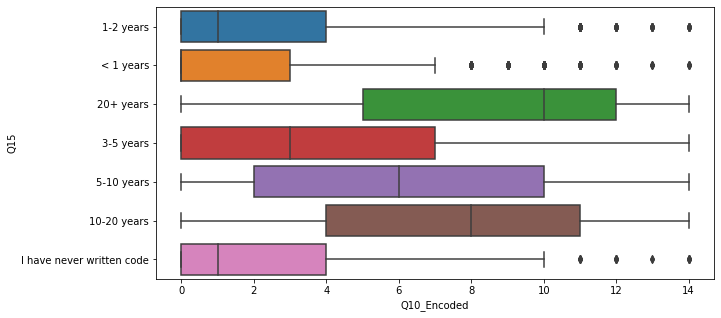

In [68]:
# plot the relation between coding experience and salary
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q15',data=df)

Ordered values: we can encode them as numerical data.

In [69]:
# encode each bin as numerical data
Q15_encode = {
    'I have never written code': 0,
    '< 1 years': 1,
    '1-2 years': 2,
    '3-5 years': 3,
    '5-10 years': 4,
    '10-20 years': 5,
    '20+ years': 6
}
# map the encoding
df.loc[:,'Q15'] = df.loc[:,'Q15'].map(Q15_encode)

<AxesSubplot:xlabel='Q15', ylabel='Q10_Encoded'>

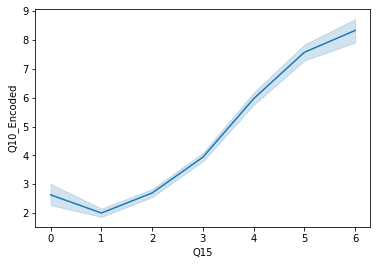

In [70]:
sns.lineplot(data=df,
            x="Q15",
            y="Q10_Encoded")

An overall trend of increased salary with increased coding experience.

## TPU experience and salary

In [71]:
# look at numbers of different answers
df.groupby('Q22').size()

Q22
2-5 times      657
6-24 times     119
> 25 times     104
Never         7319
Once           829
dtype: int64

In [72]:
df['Q22'].unique()

array(['Never', 'Once', '6-24 times', '2-5 times', nan, '> 25 times'],
      dtype=object)

In [73]:
# number of nan rows
df['Q22'].isnull().sum(axis = 0)

1329

Since there is a large number of missing value for this question, let's check if the datapoints of the missing vlues and those with non-missing values have similar normalized distribution in salary bins.

In [74]:
# compare normalized distribution of the encoded salary values between missing and non-missing value datapoints
a = df['Q10_Encoded'].value_counts(normalize=True)
b = df[df['Q22'].isnull()]['Q10_Encoded'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN Q22':b}))

       Alldata   NaN Q22
0.0   0.304432  0.466516
1.0   0.109588  0.112867
2.0   0.078691  0.067720
3.0   0.058125  0.041384
4.0   0.057256  0.042889
5.0   0.059187  0.043642
6.0   0.047794  0.025583
7.0   0.044221  0.025583
8.0   0.034469  0.024078
9.0   0.032538  0.030850
10.0  0.062953  0.039127
11.0  0.042387  0.019564
12.0  0.037269  0.027088
13.0  0.013131  0.009029
14.0  0.017959  0.024078


The salary distribution between datapoints with and without missing value seem to be similar. We can replace the missing values with the mode, which is "Never" in this case.

In [75]:
# replace 
df.loc[df['Q22'].isnull(),'Q22'] = "Never"

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q22'>

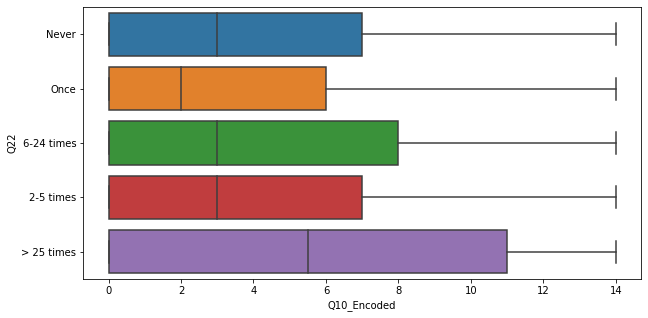

In [76]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q22',data=df)

TPU experience has inherent order: we can encode them as numerical data.

In [77]:
# encode each bin as numerical data
Q22_encode = {
    'Never': 0,
    'Once': 1,
    '2-5 times': 2,
    '6-24 times': 3,
    '> 25 times': 4
}
# map the encoding
df.loc[:,'Q22'] = df.loc[:,'Q22'].map(Q22_encode)

<AxesSubplot:xlabel='Q22', ylabel='Q10_Encoded'>

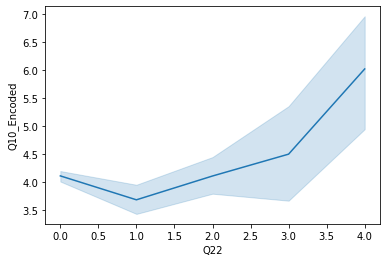

In [78]:
sns.lineplot(data=df,
            x="Q22",
            y="Q10_Encoded")

A general trend of increased salary with increased TPU experience above Never.

## ML experience and salary

In [79]:
df['Q23'].unique()

array(['1-2 years', '2-3 years', '< 1 years', '10-15 years', '3-4 years',
       '4-5 years', '5-10 years', nan, '20+ years'], dtype=object)

In [80]:
# look at numbers of different answers
df.groupby('Q23').size()

Q23
1-2 years      2328
10-15 years     282
2-3 years      1356
20+ years       162
3-4 years       851
4-5 years       777
5-10 years      739
< 1 years      2525
dtype: int64

In [81]:
# number of nan rows
df['Q23'].isnull().sum(axis = 0)

1337

In [82]:
# compare normalized distribution of the encoded salary values between missing and non-missing value datapoints
a = df['Q10_Encoded'].value_counts(normalize=True)
b = df[df['Q23'].isnull()]['Q10_Encoded'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN Q23':b}))

       Alldata   NaN Q23
0.0   0.304432  0.465221
1.0   0.109588  0.112191
2.0   0.078691  0.067315
3.0   0.058125  0.041137
4.0   0.057256  0.043381
5.0   0.059187  0.043381
6.0   0.047794  0.026178
7.0   0.044221  0.026926
8.0   0.034469  0.023934
9.0   0.032538  0.030666
10.0  0.062953  0.038893
11.0  0.042387  0.019447
12.0  0.037269  0.027674
13.0  0.013131  0.009723
14.0  0.017959  0.023934


The salary distribution between datapoints with and without missing value seem to be similar. We can replace the missing values with the mode, which is "< 1 years" in this case.

In [83]:
# replace 
df.loc[df['Q23'].isnull(),'Q23'] = "< 1 years"

In [84]:
# droping na rows
#df = df.dropna(subset = ['Q23']).reset_index(drop = True)

<AxesSubplot:xlabel='Q10_Encoded', ylabel='Q23'>

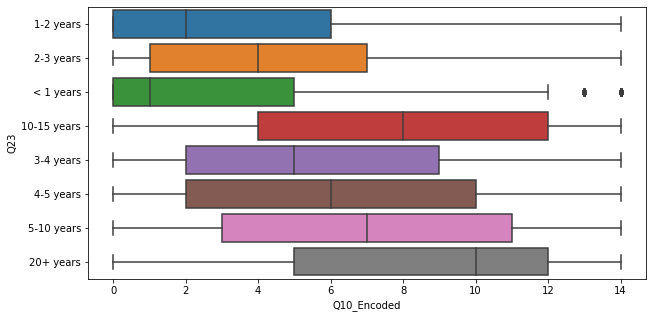

In [85]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Q10_Encoded',y='Q23',data=df)

Ordered values: we can encode them into numerical data.

In [86]:
# encode each bin as numerical data
Q23_encode = {
    '< 1 years': 0,
    '1-2 years': 1,
    '2-3 years': 2,
    '3-4 years': 3,
    '4-5 years': 4,
    '5-10 years': 5,
    '10-15 years': 6,
    '20+ years': 7
}
# map the encoding
df.loc[:,'Q23'] = df.loc[:,'Q23'].map(Q23_encode)

<AxesSubplot:xlabel='Q23', ylabel='Q10_Encoded'>

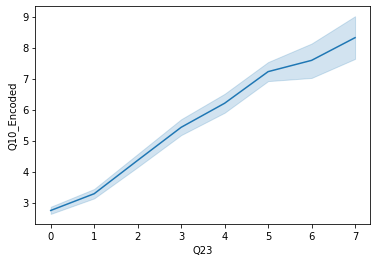

In [87]:
sns.lineplot(data=df,
            x="Q23",
            y="Q10_Encoded")

A clear trend of increased salary with increased ML experience.

### Remove columns not needed, including columns that are dummy coded into other columns and columns that does not relate to salary (e.g., Q19: programming language recommanded for others).

In [88]:
# extra columns to remove
remove = ['Q3', 'Q10','Q19','Q10_buckets']
df = df.drop(remove, axis = 1)

# (2) Feature selection

### Recursive Feature Elimination

scikit-learn:

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html


In [89]:
# separate the response variable from the predictors
Y = df['Q10_Encoded']
X = df.drop('Q10_Encoded', axis=1)

In [90]:
# save the column names for saving the top10 features later on
colNames = X.columns

Rescaling the predictor values to the same scale to avoid different weighting of importance for the model later on.

In [91]:
# rescale predictors
scaler = StandardScaler()
X = scaler.fit_transform(X.astype(float)) #change type to float for rescaling

### Ordinal multiclass logistic regression

Since the predicted variable in our case is ordinal multicalss data, we can solve the ordinal multiclass logistic regression as a series of binary classification:

We can take advantage of the ordered class value by transforming a k-class ordinal regression problem to a k-1 binary classification problem by convert an ordinal attribute A* with ordinal value V1, V2, V3, … Vk into k-1 binary attributes, one for each of the original attribute’s first k − 1 values. The ith binary attribute represents the test A* > Vi [1]

e.g.,
1. binary target is 1 if salary > 1, so the classifier will predict Pr(salary > 1)
2. binary target is 1 if salary > 2, so the classifier will predict Pr(salary > 2)
3. binary target is 1 if salary > 3, so the classifier will predict Pr(salary > 3)
4. binary target is 1 if salary > 4, so the classifier will predict Pr(salary > 4)
...
etc

Then, to calculate probability of belonging to each salary bucket:

Pr(y=1) = 1-Pr(salary > 1)

Pr(y=2) = Pr(salary > 1)-P(salary > 2)

Pr(y=3) = Pr(salary > 2)-P(salary > 3)

Pr(y=4) = Pr(salary > 3)-P(salary > 4)
...
etc

Code adapted from: https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c


In [92]:
# define a class to solve ordinal multiclass logistic regression as a series of binary classification.

from sklearn.base import clone

class OrdinalClassifier():
    
    # The parameter that defines our OrdinalClassifier is
    # clf: any sklearn classifier that implements predict_proba method in it
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [95]:
# specify the OrdinalClassifier to take logistic regression as its classifier
model = OrdinalClassifier(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'))

In [96]:
rfe = RFE(model.clf,n_features_to_select=10)
fit = rfe.fit(X, Y)
Top10 = colNames[fit.ranking_ == 1]
Top10

Index(['Q1', 'Q6', 'Q7', 'Q11', 'Q15', 'world_region_Asia_CSAmerica_Africa',
       'world_region_Europe_MidEast', 'world_region_NAmerica_Oceania',
       'Q5_Data Analyst', 'Q8_No'],
      dtype='object')

In [97]:
# extract the top10 features as predictors
X_selected = df[Top10]

In [98]:
# take values and rescale selected predictors
X = scaler.fit_transform(X_selected.values.astype(float))
Y = Y.values

In [99]:
# spliting the predicted and predictor variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=245, test_size=0.3)

In [100]:
# fit the training model using the selected features
model.fit(X_train, y_train)

In [101]:
predictions = model.predict(X_test)

In [102]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.metrics import classification_report

In [103]:
# look at the confusion matrix
print('Confusion Matrix\n')
print(confusion_matrix(y_test,predictions))

Confusion Matrix

[[846   1   0   2  11  26   2   4   0   0  29   1   3   0   0]
 [292   0   1   6   5  10   0   1   0   0  10   0   1   0   0]
 [212   1   0   2  14  15   0   0   0   0   8   0   0   0   0]
 [131   2   2   4  16  17   1   2   0   0   9   1   1   0   0]
 [119   5   1   2  10  19   3   2   0   0  25   1   0   0   0]
 [117   0   0   0  12  24   1   6   1   0  30   1   2   0   0]
 [ 63   1   0   4  14  16   0   9   1   0  47   3   1   0   0]
 [ 64   1   0   5  10  10   1   5   0   0  46   2  10   0   0]
 [ 33   0   4   1   7   6   1   4   1   1  38   2   3   0   0]
 [ 21   0   1   0   7   6   0   3   1   0  39   3   5   0   1]
 [ 43   0   0   0   2  13   1   7   1   0  85   8  24   0   0]
 [ 20   0   0   2   3   8   0   4   0   0  65   5  29   0   0]
 [  8   0   0   0   4   5   0   0   0   0  50  11  31   0   2]
 [  6   0   0   0   1   0   0   0   0   0  16   2  15   0   2]
 [ 12   0   1   0   1   2   0   0   0   0  16   2  28   0   2]]


In [104]:
# look at accuracy
accuracy_score(y_test,predictions)

0.3259330759330759

The model trained on training set has a very low accuracy at about 32.59% on the test set.

In [105]:
# take a look at other performance measures of the trained model on test set
target_classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14']
print(classification_report(y_test,predictions,target_names = target_classes))

              precision    recall  f1-score   support

           0       0.43      0.91      0.58       925
           1       0.00      0.00      0.00       326
           2       0.00      0.00      0.00       252
           3       0.14      0.02      0.04       186
           4       0.09      0.05      0.07       187
           5       0.14      0.12      0.13       194
           6       0.00      0.00      0.00       159
           7       0.11      0.03      0.05       154
           8       0.20      0.01      0.02       101
           9       0.00      0.00      0.00        87
          10       0.17      0.46      0.24       184
          11       0.12      0.04      0.06       136
          12       0.20      0.28      0.23       111
          13       0.00      0.00      0.00        42
          14       0.29      0.03      0.06        64

   micro avg       0.33      0.33      0.33      3108
   macro avg       0.12      0.13      0.10      3108
weighted avg       0.19   

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using the hold-out method of model training on the selected variables, we got an accuracy of around 18.79% on the test set. Now we can change the model training method to cross-validation and see if we can improve our model to have higher accuracy on predicting the test set.

# (3,4) Model Implementation and Model Tuning

In [106]:
## cross-validation on the training data.
## For each fold, a different subfold of the training data will be assigned as the test set for model accuracy calculation
model = OrdinalClassifier(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'))
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_selected)

accuracy = np.zeros(10)
np_idx = 0


for train_idx, test_idx in kfold.split(X_selected):
    np_idx = np_idx + 1
    
    # In each fold, the test set would be a different subset of the training set
    X_train, X_test = X_selected.values[train_idx], X_selected.values[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]  # Y has already taken values
    
    X_train = scaler.fit_transform(X_train.astype(float))  # change type to float for rescaling
    X_test = scaler.transform(X_test.astype(float))
    
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    
    ACC = accuracy_score(y_test,pred)

    print ("Fold {}: Accuracy: {}%".format(np_idx,round(ACC,3)))
    
    accuracy[np_idx-1] = ACC*100
    
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.284%
Fold 2: Accuracy: 0.325%
Fold 3: Accuracy: 0.338%
Fold 4: Accuracy: 0.316%
Fold 5: Accuracy: 0.319%
Fold 6: Accuracy: 0.366%
Fold 7: Accuracy: 0.34%
Fold 8: Accuracy: 0.337%
Fold 9: Accuracy: 0.402%
Fold 10: Accuracy: 0.388%
Average Score: 34.142%(3.357%)


We can see that using cross-validation on the training set improves the accuracy from the holdout method to 34.142% on average. To optimize the model, we will next do hyperparameter tuning through a grid search process to find the best combination of hyperparameters that gives the highest accuracy rate as the optimal model.

In [117]:
## THIS CHUNK TAKES TIME
## RESULTS PRINTED AS MARKDOWN TEXT AND HARD-CODED BELOW
#### This chunk runs for about 11 mins ####
# Grid search with cv

#model = OrdinalClassifier(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'))
#kfold = KFold(n_splits=10)
#kfold.get_n_splits(X_selected)

#best_model = model
#best_params = {}
#best_accuracy = 0
#best_std = 0

#i = 0

#train_mean_acc = np.zeros(14)
#test_mean_acc = np.zeros(14)
#rain_mean_std = np.zeros(14)
#test_mean_std = np.zeros(14)
#train_mean_err = np.zeros(14)
#test_mean_err = np.zeros(14)

# sepecify the candidate hyperparameters for tuning
# loop through hyperparameter combinations
#for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
#    for penalty in ['l1','l2']:

        # update model hyperparameter for each loop
#        model = OrdinalClassifier(LogisticRegression(solver = 'liblinear', multi_class = 'ovr', C=C, penalty=penalty))
#        train_acc_list = np.zeros(10)
#        test_acc_list = np.zeros(10)
#        train_err_list = np.zeros(10)
#        test_err_list = np.zeros(10)
    
        
#        np_idx = 0
        
        # loop through cv folds
#        for train_idx, test_idx in kfold.split(X_selected):
#            X_train, X_test = X_selected.values[train_idx], X_selected.values[test_idx]
#            y_train, y_test = Y[train_idx], Y[test_idx]

#            X_train = scaler.fit_transform(X_train.astype(float))
#            X_test = scaler.transform(X_test.astype(float))

#            model.fit(X_train, y_train)
            
            # take accuracy of each fold
#            train_acc_list[np_idx] = accuracy_score(y_train,model.predict(X_train))
#            test_acc_list[np_idx] = accuracy_score(y_test,model.predict(X_test))
            
            # take prediction error of each fold
#            train_err_list[np_idx] = mean_squared_error(y_train,model.predict(X_train))
#            test_err_list[np_idx] = mean_squared_error(y_test,model.predict(X_test))
            
#            np_idx += 1
            
            
        # take mean accuracy and error aross all cv folds under each hyperparameter combination loop
#        train_mean_acc[i] = np.mean(train_acc_list)
#        test_mean_acc[i] = np.mean(test_acc_list)
#        train_mean_std[i] = np.std(train_acc_list)
#        test_mean_std[i] = np.std(test_acc_list)
#        train_mean_err[i] = np.mean(train_err_list)
#        test_mean_err[i] = np.mean(test_err_list)
            
#        i += 1
        
#        if np.mean(test_acc_list) > best_accuracy:
#            best_model = model
#            best_params = {'C':C, 'penalty': penalty}
#            best_accuracy = np.mean(test_acc_list)  # the higher the accuracy: the higher the variance, the lower the bias
#            best_std = np.std(test_acc_list)  # the higher the std: the higher the variance, the lower the bias
            
#print (best_params)
#print ("Best Score: {}%({}%)".format(round(best_accuracy*100,3),round(best_std*100,3)))      

#print ("\nThe optimal model uses C={}, and a {} penalty, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['penalty'],round(best_accuracy*100,3),round(best_std*100,3)))

Printed results:

{'C': 0.1, 'penalty': 'l2'}
Best Score: 34.557%(3.403%)

The optimal model uses C=0.1, and a l2 penalty, and has a cross validation score of 34.557% with a standard deviation of 3.403%

After finding the optimal model through hyperparameter tuning, we got an accuracy of around 34.152% and std of 3.32% with the optimal model using C=0.1 and a l2 penalty.

The next step will discuss why is the optimal model optimal from the angle of bias-variance trade-off under different hyperparameters C.

### Bias-Variance trade-off justification of the optimal model

In [108]:
## THIS CHUNK RELIES ON OUTPUT FROM THE ABOVE TIME-CONSUMING CV FOR LOOPS
## HARD-CODED IN THE NEXT CHUNK

# since the optimal penalty is l2, only take the measures resulting from l2 penalty over all C candidates
#l2_ind = [1,3,5,7,9,11,13]

#C = pd.DataFrame([0.001, 0.01, 0.1, 1, 10, 100, 1000], columns = ['C'])
#train_accuracy = pd.DataFrame(train_mean_acc[l2_ind],columns = ['train_accuracy'])
#test_accuracy = pd.DataFrame(test_mean_acc[l2_ind], columns = ['test_accuracy'])
#train_std = pd.DataFrame(train_mean_std[l2_ind], columns = ['train_std'])
#test_std = pd.DataFrame(test_mean_std[l2_ind], columns = ['test_std'])
#train_MSE = pd.DataFrame(train_mean_err[l2_ind], columns = ['train_MSE'])
#test_MSE = pd.DataFrame(test_mean_err[l2_ind], columns = ['test_MSE'])

# concat all measures into one df
#result_df = pd.concat([C, train_accuracy,test_accuracy,train_std,test_std,train_MSE,test_MSE], axis=1, sort=False)

In [118]:
## Hard-code the hyperparameter tuning cv results
C = pd.DataFrame([0.001, 0.01, 0.1, 1, 10, 100, 1000], columns = ['C'])
train_accuracy = pd.DataFrame([0.307178,0.342420,0.344952,0.345070,0.344834,0.344780,0.344780],columns = ['train_accuracy'])
test_accuracy = pd.DataFrame([0.307056,0.340071,0.341518,0.341422,0.341035,0.341132,0.341132], columns = ['test_accuracy'])
train_std = pd.DataFrame([0.005014,0.003764,0.003204,0.003129,0.003114,0.003148,0.003148], columns = ['train_std'])
test_std = pd.DataFrame([0.045629,0.034577,0.033201,0.033570,0.034093,0.034047,0.034047], columns = ['test_std'])
train_MSE = pd.DataFrame([23.353986,14.264396,13.179044,13.047978,13.027981,13.024473,13.024473], columns = ['train_MSE'])
test_MSE = pd.DataFrame([23.314272,14.227094,13.250369,13.087100,13.063629,13.055127,13.055127], columns = ['test_MSE'])

# concat all measures into one df
result_df = pd.concat([C, train_accuracy,test_accuracy,train_std,test_std,train_MSE,test_MSE], axis=1, sort=False)

In [119]:
result_df

,C,train_accuracy,test_accuracy,train_std,test_std,train_MSE,test_MSE
0,0.001,0.307178,0.307056,0.005014,0.045629,23.353986,23.314272
1,0.010,0.342420,0.340071,0.003764,0.034577,14.264396,14.227094
2,0.100,0.344952,0.341518,0.003204,0.033201,13.179044,13.250369
3,1.000,0.345070,0.341422,0.003129,0.033570,13.047978,13.087100
4,10.000,0.344834,0.341035,0.003114,0.034093,13.027981,13.063629
5,100.000,0.344780,0.341132,0.003148,0.034047,13.024473,13.055127
6,1000.000,0.344780,0.341132,0.003148,0.034047,13.024473,13.055127


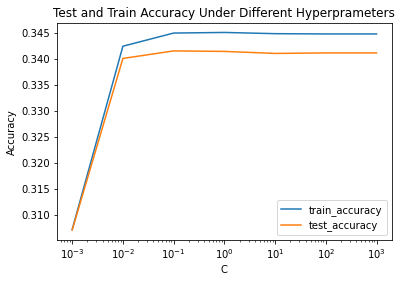

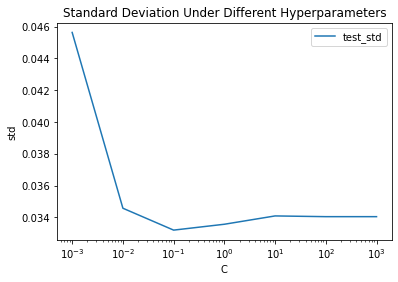

In [120]:
# plot test and train accuracy changes with C
plot1 = result_df.plot(x="C", y=["train_accuracy", "test_accuracy"],  logx=True, title = 'Test and Train Accuracy Under Different Hyperprameters')
plot1.set_xlabel('C')
plot1.set_ylabel('Accuracy')
plt.show()

# plot test std changes with C
plot2 = result_df.plot(x="C", y=["test_std"],  logx=True, title = 'Standard Deviation Under Different Hyperparameters')
plot2.set_xlabel('C')
plot2.set_ylabel('std')
plt.show()

When hyperparameter C increases, the model accuracy on training set increases. On the other hand, the model accuracy on the test set first increases and then descreases, with the **highest accuracy shows up at C=0.1**.

As shown in the result of hyperparameter tuning, hyperparameter combination that results in the optimal model is l2 penalty and C = 0.1, giving an accuracy of about 34.557% and a standard deviation of 3.403.

**(1) If C increases from 0.1, variance increases and the accuracy on training set increases but the accuracy on test set decreases.**

This means that the model would overfit to the training set and would not generalize well onto the test set.

**(2) If C decreases from 0.1, variance increases but the accuracy rates on both trainging and test set decrease.**

This means that the model would underfit the data, generating an ill-performed model that gives higher mean squared error and lower accuracy on new dataset.

Therefore, from the accuracy and standard deviation plots, changes in bias-variance trade-off can be discussed at different hyperparameters C. In conclusion, the optimal model we derived selected the best point of hyperparameter C=0.1.


# (5) Testing & Discussion

In [121]:
## use the optimal model to predict training and test sets
# the optimal model
model = OrdinalClassifier(LogisticRegression(solver = 'liblinear', multi_class = 'ovr', C = 0.1, penalty = 'l2'))

# fit to train set and compare the accuracy between train and test set preidctions
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=245)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# accuracy 
print('\nTrain Accuracy: {:.2f}%\n'.format(accuracy_score(y_train,train_pred)*100))
print('\nTest Accuracy: {:.2f}%\n'.format(accuracy_score(y_test,test_pred)*100))

# mean squred error
print('\nTrain MSE: {:.2f}\n'.format(mean_squared_error(y_train,train_pred)))
print('\nTest MSE: {:.2f}\n'.format(mean_squared_error(y_test,test_pred)))

#print('\nTrain Classification Report\n')
#print(classification_report(y_train, train_pred, target_names=target_classes))

#print('\nTest Classification Report\n')
#print(classification_report(y_test, test_pred, target_names=target_classes))




Train Accuracy: 35.33%


Test Accuracy: 32.63%


Train MSE: 12.91


Test MSE: 13.92



In [113]:
result_df

,C,train_accuracy,test_accuracy,train_std,test_std,train_MSE,test_MSE
0,0.001,0.307178,0.307056,0.005014,0.045629,23.353986,23.314272
1,0.010,0.342420,0.340071,0.003764,0.034577,14.264396,14.227094
2,0.100,0.344952,0.341518,0.003204,0.033201,13.179044,13.250369
3,1.000,0.345070,0.341422,0.003129,0.033570,13.047978,13.087100
4,10.000,0.344834,0.341035,0.003114,0.034093,13.027981,13.063629
5,100.000,0.344780,0.341132,0.003148,0.034047,13.024473,13.055127
6,1000.000,0.344780,0.341132,0.003148,0.034047,13.024473,13.055127


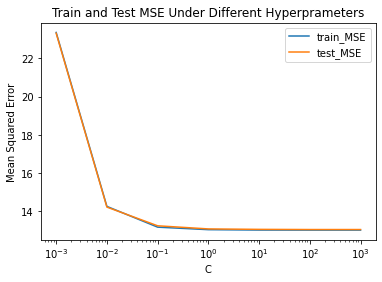

In [114]:
# plot train and test MSE changes with C
plot3 = result_df.plot(x="C", y=["train_MSE","test_MSE"], logx=True, title = 'Train and Test MSE Under Different Hyperprameters')
plot3.set_xlabel('C')
plot3.set_ylabel('Mean Squared Error')
plt.show()

In [115]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/pyplot.py'>

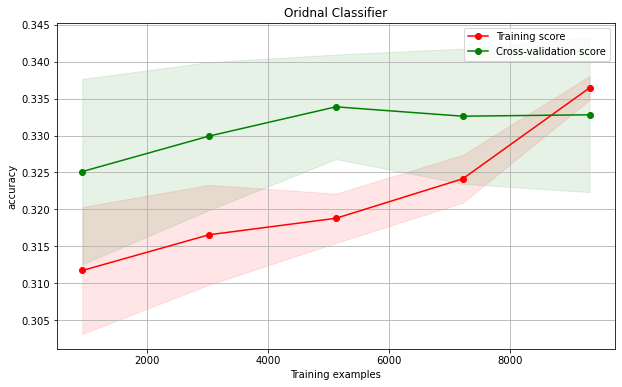

In [116]:
model = OrdinalClassifier(LogisticRegression(solver = 'liblinear', multi_class = 'ovr', C = 0.1, penalty = 'l2'))

plot_learning_curve(model.clf,'Oridnal Classifier', X_selected, Y, cv=10)

Judging from how close the train and test accuracy rates and MSE are, it is likely that the optimal model has **high bias** and is **overall underfitted** to the train dataset. This could mean that **the model is not presenting a very accurate or representative picture of the relationship between the inputs and predicted output**. The model may generalize well on test or new datasets in terms of outputing similar prediction accuracy rates as that of the trained dataset.

To support the underfitting argument to the model, we can look at the graph above to see how the Train and Test MSE change under different hyperparameter C (indexing model complexity). As discussed previously, training model with C=0.1 gives the highest test set prediction accuracy. However, C=0.1 does not result in the lowest squared error. The MSE of both training and test set acutally continued to decrease untill C=100 and persisted through C=1000. This suggests that the current optimal model is underfitted to the training data since the error is not minimized. The learning curve prediction ploted above also shows evidence the the model is underfitted (with training accuracy even lower than validation set) with the size of our training sample (around 7000 data points). 

Since the current optimal model has high bias, we may think about fixing the model by increasing model complexity (C), in turn, increase the model variance to trade-off the bias. For example, if we increase C from 0.1 to 1, we can see from the below table that training accuracy acctually increases. However, the improvement on the training set accuracy comes at the cost of the test set accuracy (deviating from the optimal model that output the highest accuracy for prediction on test set.)
